In [1]:
import time
import os
import pandas as pd
import numpy as np
from collections import Counter
import re
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sea
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from gensim.models import word2vec
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
#from wordcloud import WordCloud, STOPWORDS

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Activation, Embedding, Flatten, Dropout, CuDNNLSTM
from keras.utils import to_categorical
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


import warnings
warnings.filterwarnings('ignore')

/Users/manish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/manish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/manish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/manish/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

In [2]:
data_columns = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names = data_columns)

In [3]:
print('Number of instances : {}'.format(data.shape[0]))
print('-'*100)
data.info()

Number of instances : 1600000
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
target    1600000 non-null int64
ids       1600000 non-null int64
date      1600000 non-null object
flag      1600000 non-null object
user      1600000 non-null object
text      1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [6]:
%%time
data.target = data.target.apply(lambda x: decode_sentiment(x))

CPU times: user 616 ms, sys: 8.72 ms, total: 625 ms
Wall time: 638 ms


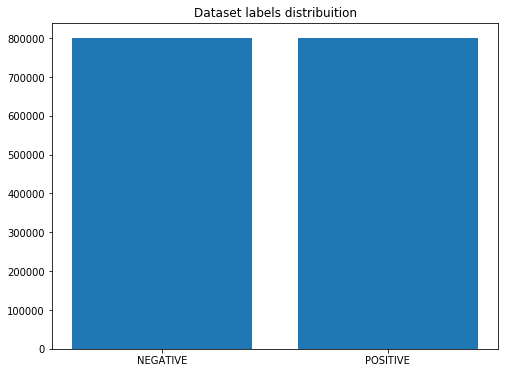

In [7]:
target_cnt = Counter(data.target)

plt.figure(figsize=(8,6))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")
plt.show()

In [8]:
stop_words = stopwords.words('spanish')
stemmer = SnowballStemmer('english')

In [9]:
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
%%time
data.text = data.text.apply(lambda x: preprocess(x))

CPU times: user 1min 50s, sys: 1.02 s, total: 1min 51s
Wall time: 1min 56s


In [11]:
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 23)
print('Train Size : {}'.format(len(data_train)))
print('Test Size : {}'.format(len(data_test)))

Train Size : 1280000
Test Size : 320000


In [12]:
data.text[0]

'awww that s bummer you shoulda got david carr of third day to do it d'

In [13]:
%%time
documents = [_text.split() for _text in data_train.text] 

CPU times: user 4.89 s, sys: 719 ms, total: 5.61 s
Wall time: 6.13 s


In [14]:
w2v_model = word2vec.Word2Vec(size=300, 
                              window=10, 
                               min_count=10
                              )

In [15]:
w2v_model.build_vocab(documents)

In [16]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words) + 1
print("Vocab size", vocab_size)

Vocab size 30431


In [17]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

CPU times: user 35min 51s, sys: 25.1 s, total: 36min 17s
Wall time: 15min 45s


(394507632, 520625696)

In [18]:
w2v_model.most_similar("crazy")

[('insane', 0.5211676359176636),
 ('nuts', 0.4617881774902344),
 ('crazyyy', 0.4480739235877991),
 ('weird', 0.39852774143218994),
 ('nutz', 0.3498986065387726),
 ('wack', 0.3438376188278198),
 ('wierd', 0.3417133688926697),
 ('mad', 0.3397127389907837),
 ('strange', 0.3174181878566742),
 ('crazyy', 0.31542789936065674)]

In [19]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train.text)

voacb_size = len(tokenizer.word_index) + 1
print('Total words', vocab_size)

Total words 30431
CPU times: user 34.2 s, sys: 909 ms, total: 35.1 s
Wall time: 36.1 s


In [20]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(data_train.text), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(data_test.text), maxlen=300)

CPU times: user 44.9 s, sys: 4.22 s, total: 49.1 s
Wall time: 53.5 s


In [21]:
labels = data_train.target.unique().tolist()
labels.append('NEUTRAL')
labels

['NEGATIVE', 'POSITIVE', 'NEUTRAL']

In [22]:
encoder = LabelEncoder()
encoder.fit(data_train.target.tolist())

y_train = encoder.transform(data_train.target.tolist())
y_test = encoder.transform(data_test.target.tolist())

In [23]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [24]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [25]:
y_train[:10]

array([[0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]])

In [72]:
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        
print(embedding_matrix.shape)

(30431, 300)


In [80]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [81]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 300, 300)          9129300   
_________________________________________________________________
dropout_8 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 120)               202080    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 121       
Total params: 9,331,501
Trainable params: 202,201
Non-trainable params: 9,129,300
_________________________________________________________________


In [82]:
model.compile(loss='binary_crossentropy',
              optimizer="SGD",
              metrics=['accuracy'])

In [83]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=1000,
                    epochs=5,
                    verbose=-1
                    )

Epoch 1/5


InvalidArgumentError: indices[190,299] = 284952 is not in [0, 30431)
	 [[{{node embedding_7/embedding_lookup}}]]

In [43]:
%%time
score = model.evaluate(x_test, y_test, batch_size=1024)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

InvalidArgumentError: indices[452,293] = 40168 is not in [0, 30431)
	 [[{{node embedding/embedding_lookup}}]]

In [32]:
SENTIMENT_THRESHOLDS = (0.4, 0.7)

def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = 'NEUTRAL'
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = 'NEGATIVE'
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = 'POSITIVE'

        return label
    else:
        return 'NEGATIVE' if score < 0.5 else 'POSITIVE'

In [33]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=300)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at} 

In [34]:
predict("I love the music")

{'label': 'NEUTRAL',
 'score': 0.4982355237007141,
 'elapsed_time': 0.2534339427947998}

In [35]:
predict('I hate the rain')

{'label': 'NEUTRAL',
 'score': 0.4602612257003784,
 'elapsed_time': 0.08620119094848633}

In [36]:
predict('I dont know what I am doing')

{'label': 'NEUTRAL',
 'score': 0.4698605239391327,
 'elapsed_time': 0.07497692108154297}

In [37]:
predict('I dont know what I am doing')

{'label': 'NEUTRAL',
 'score': 0.4698605239391327,
 'elapsed_time': 0.07338118553161621}

In [38]:
%%time
y_pred_1d = []
y_test_1d = list(data_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

InvalidArgumentError: indices[4511,290] = 66838 is not in [0, 30431)
	 [[{{node embedding/embedding_lookup}}]]

In [39]:
print('Accuracy on the test data : {}'.format(accuracy_score(y_pred_1d, y_test_1d)))
print()
print(classification_report(y_pred_1d, y_test_1d))

ValueError: Found input variables with inconsistent numbers of samples: [0, 320000]